In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Network

## Day - 15; Session - 02; CNN with Regularization Technique (Data Augmnetation); Tensorflow; AlexNet

## Flower Recognition Data

In [18]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, r'G:\My Drive\DNN')

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf

from utils.helper import fn_plot_tf_hist

In [19]:
###----------------------
### Some basic parameters
###----------------------


inpDir = '../Input' # location where input data is stored
outDir = '../Output' # location to store outputs
modelDir = './Models'
subDir = 'flower_photos'
valDir = 'valid_flowers'
altName = 'cnn_base'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

TEST_SIZE = 0.2

ALPHA = 0.001
EPOCHS = 10 # number of cycles to run
FLIP_MODE = 'horizontal_and_vertical'
ROTATION = (-0.1, 0.1)
PATIENCE = 20
LR_PATIENCE = 10
FACTOR_LR = 0.5
BATCH_SIZE = 8 # inline of Training Rows being 60000
IMG_HEIGHT = 200
IMG_WIDTH = 200

REG_LAMBDA = 0.001
PATIENCE = 20 # EarlyStopping -> If n no. of epochs give similar o/p, then it will stop the execution
LR_PATIENCE = 10
LR_FACTOR = 0.1

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [7]:
print (physical_devices)

[]


In [20]:
def fn_plot_label(tr_ds, ts_ds):

    plt.figure(figsize = (15,5)) # instantiate the figure

    plt.subplot(1,2,1) # first out of 2

    train_labels = tf.concat([lbl for img, lbl in tr_ds], axis = 0).numpy() # get the labels(2936); Here tr_ds is Batch(32) data as training dataset

    unique, _, counts = tf.unique_with_counts(train_labels) # get counts

    plt.bar(range(len(unique)), counts, align='center', color = 'DarkBlue') # barplot the counts

    plt.xticks(range(len(unique)), class_names)

    plt.title('Training Set')

    plt.subplot(1,2,2)

    test_labels = tf.concat([lbl for img, lbl in ts_ds], axis = 0).numpy()

    unique, _, counts = tf.unique_with_counts(test_labels)

    plt.bar(range(len(unique)), counts, align='center', color = 'Orange')

    plt.xticks(range(len(unique)), class_names)

    plt.title('Test Set')


In [21]:
# import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                    fname='flower_photos',
#                                    untar=True)
# data_dir = pathlib.Path(data_dir)


data_dir = os.path.join(inpDir, subDir)
data_dir

'../Input\\flower_photos'

In [22]:
os.listdir(data_dir)

['LICENSE.txt', 'roses', 'sunflowers', 'daisy', 'dandelion', 'tulips']

In [23]:
# create training data
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='training', # purpose
    seed=RANDOM_STATE,
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)
# test data
test_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='validation', # purpose
    seed=RANDOM_STATE,
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [24]:
# is it picking class names
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [25]:
class_labels = {k : v for k, v in enumerate(class_names)}
class_labels

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [26]:
num_classes = len(class_names)

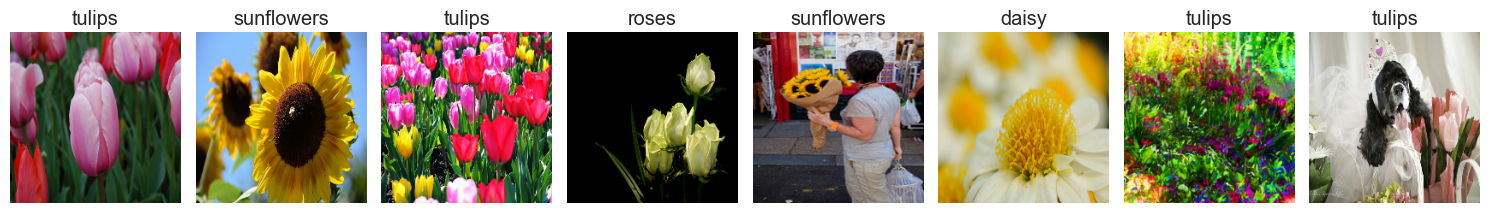

In [27]:
plt.figure(figsize=(15,8))

# Plotting Batch 1
for images, labels in train_ds.take(1):
    for i in range (BATCH_SIZE):
        plt.subplot(int(BATCH_SIZE/8), 8, i +1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
plt.show()

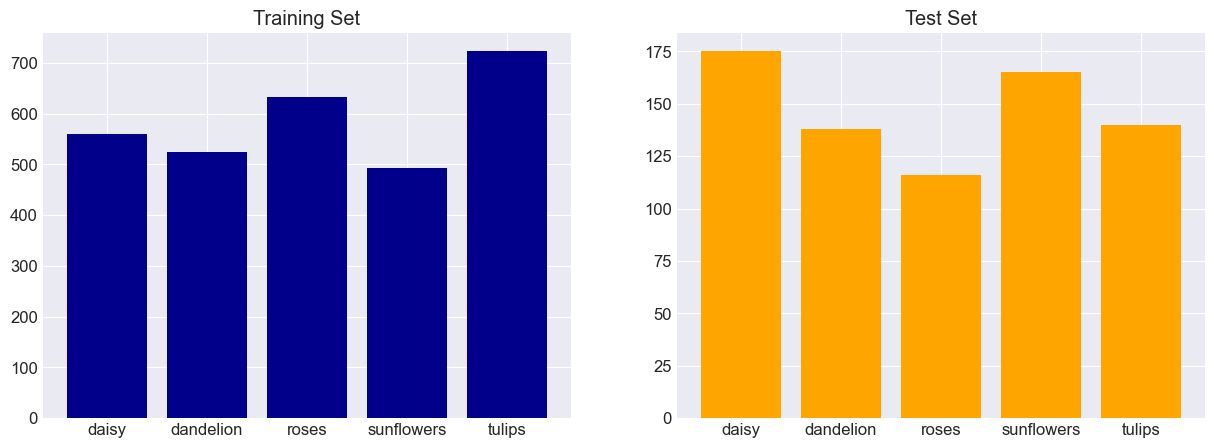

In [28]:
fn_plot_label(train_ds, test_ds)

In [29]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3) # 3 Channels for R, G, B
input_shape

(200, 200, 3)

In [30]:
# tf.keras.applications.DenseNet169(): Instantiates the Densenet169 architecture.

densenet_model = tf.keras.applications.DenseNet169(
    include_top=False, # whether to include the fully-connected layer at the top of the network.
    weights='imagenet', # pre-Trained Weights of ImageNet / ImageNet Large Scale Visual Recognition Challenge (ILSVRC)
    input_shape=input_shape
)



51877672/51877672 [==============================] - 5s 0us/step


In [31]:
for layer in densenet_model.layers:
    layer.trainable = False

In [32]:
densenet_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 206, 206, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 100, 100, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1/conv[0][0]']

In [33]:
def build_model(num_classes):
  
  knl_init = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)
  model = tf.keras.Sequential()

  # Pre-processing
  model.add(tf.keras.layers.Rescaling(1./255.))

  #  Augmentation Layers

  model.add(tf.keras.layers.RandomRotation((-0.5, 0.5), fill_mode = 'nearest', seed = RANDOM_STATE))


  ## Data Augmentation

  model.add(densenet_model)


  ####
  # HEAD
  ####
  # Flatten
  model.add(tf.keras.layers.Flatten())

  # first dense set
  model.add(tf.keras.layers.Dense(1664, kernel_initializer=knl_init))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dropout(0.5))


  # second dense set
  model.add(tf.keras.layers.Dense(46, kernel_initializer=knl_init))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dropout(0.5))


  # third dense set
  model.add(tf.keras.layers.Dense(num_classes, kernel_initializer=knl_init))

  return model

In [34]:
model = build_model(num_classes)
model

In [35]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(loss= loss_fn,
              optimizer= 'adam',
              metrics=['accuracy'])

In [36]:
# checkpoint_path = os.path.join(modelDir, subDir, 'Fashion_MNIST_Early_Stopping.csv')

# model_ckpnt_callback = tf.keras.callbacks.ModelCheckpoint(
#     checkpoint_path,
#     monitor='val_loss',
#     verbose=2,
#     save_best_only=True,
#     save_weights_only=True,
#     mode='auto'
# )

# es_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=PATIENCE,
#     verbose=2,
#     mode='auto',
#     restore_best_weights=True
# )

# lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=LR_FACTOR,
#     patience=LR_PATIENCE,
#     verbose=0,
#     mode='auto',
#     min_lr=0.00001
# )

In [37]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test_ds,
                    # callbacks=[model_ckpnt_callback, es_callback, lr_callback],
                    verbose=2)

Epoch 1/10


367/367 - 361s - loss: 0.9129 - accuracy: 0.6737 - val_loss: 0.4149 - val_accuracy: 0.8420 - 361s/epoch - 983ms/step
Epoch 2/10
367/367 - 344s - loss: 0.6755 - accuracy: 0.7629 - val_loss: 0.3541 - val_accuracy: 0.8760 - 344s/epoch - 937ms/step
Epoch 3/10
367/367 - 342s - loss: 0.5862 - accuracy: 0.7946 - val_loss: 0.3413 - val_accuracy: 0.8869 - 342s/epoch - 933ms/step
Epoch 4/10
367/367 - 341s - loss: 0.5488 - accuracy: 0.8065 - val_loss: 0.3339 - val_accuracy: 0.8610 - 341s/epoch - 930ms/step
Epoch 5/10
367/367 - 343s - loss: 0.4955 - accuracy: 0.8300 - val_loss: 0.3395 - val_accuracy: 0.8815 - 343s/epoch - 935ms/step
Epoch 6/10
367/367 - 341s - loss: 0.4863 - accuracy: 0.8294 - val_loss: 0.3364 - val_accuracy: 0.8787 - 341s/epoch - 929ms/step
Epoch 7/10
367/367 - 338s - loss: 0.4799 - accuracy: 0.8375 - val_loss: 0.3234 - val_accuracy: 0.8747 - 338s/epoch - 922ms/step
Epoch 8/10
367/367 - 342s - loss: 0.4680 - accuracy: 0.8372 - val_loss: 0.2988 - val_accuracy: 0.8856 

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 200, 200, 3)       0         
 ation)                                                          
                                                                 
 densenet169 (Functional)    (None, 6, 6, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 59904)             0         
                                                                 
 dense (Dense)               (None, 1664)              99681920  
                                                                 
 batch_normalization (Batch  (None, 1664)              6656      
 Normalization)                                         

In [39]:
results = pd.DataFrame(history.history)
results

,loss,accuracy,val_loss,val_accuracy
0,0.912907,0.673706,0.414904,0.841962
1,0.675508,0.762943,0.354100,0.876022
2,0.586158,0.794619,0.341279,0.886921
3,0.548777,0.806540,0.333921,0.861035
4,0.495456,0.830041,0.339535,0.881471
5,0.486347,0.829360,0.336448,0.878747
6,0.479941,0.837534,0.323394,0.874659
7,0.467979,0.837193,0.298775,0.885559
8,0.465962,0.841962,0.312381,0.884196
9,0.424549,0.857289,0.304503,0.884196


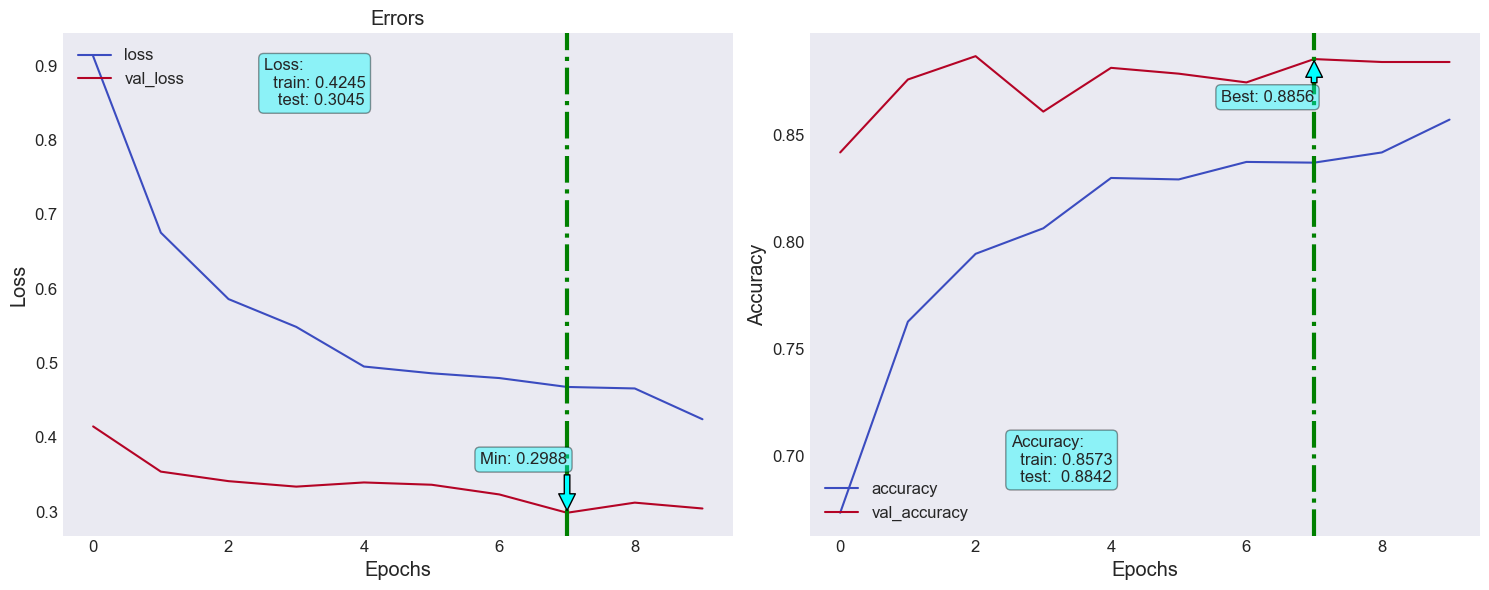

In [40]:
fn_plot_tf_hist(results)

In [41]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

92/92 [==============================] - 29s 315ms/step - loss: 0.3045 - accuracy: 0.8842


In [42]:
yhat = model.predict(test_ds)

y_test  = np.concatenate([y for X,y in test_ds], axis=0).squeeze()

y_pred = yhat.argmax(axis=1)

print('Accuracy score on Test Data: {:.4f}'.format(accuracy_score(y_test, y_pred)))

92/92 [==============================] - 34s 318ms/step
Accuracy score on Test Data: 0.1921


In [ ]:
val_dir = os.path.join(inpDir, valDir)

val_ds  = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                      validation_split=None,
                                                      seed = RANDOM_STATE,
                                                      image_size = (IMG_HEIGHT, IMG_WIDTH),
                                                      batch_size= BATCH_SIZE)

In [44]:
test_loss, test_acc = model.evaluate(val_ds, verbose=1)

In [ ]:
yhat = model.predict(test_ds)

y_test  = np.concatenate([y for X,y in test_ds], axis=0).squeeze()

y_pred = yhat.argmax(axis=1)

print('Accuracy score on Validate Data: {:.4f}'.format(accuracy_score(y_test, y_pred)))